# Effect of History

The update data has labels perturbed according to the model's FPR. However, the initial training data is static. This means that it can be used as a sort of anchor to make sure that the model's predictions on that data do not deviate too much.

1. Preventing prediction deviation on original training set will also prevent FPR from increasing.
2. We might not trust older data as definitions of disease change over time, so we need to balance this

In [58]:
import copy
import importlib
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import torch

import sklearn.linear_model as linear_model

from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

import utils
importlib.reload(utils)
from utils import eval_model, perturb_labels_fp, update_model_feedback_with_training, update_model_feedback_with_training_cumulative, make_gaussian_data

%matplotlib inline

In [37]:
def train_update_loop(n_train, n_update, n_test, update_fn, num_updates, train_percentages, seeds, data_fn):
    seeds = np.arange(seeds)
    initial_results = {update: {train_percentage: {"fpr": [], "tpr": [], "fnr": [], "tnr": []} for train_percentage in train_percentages} for update in num_updates}
    updated_results = {update: {train_percentage: {"fpr": [], "tpr": [], "fnr": [], "tnr": []} for train_percentage in train_percentages} for update in num_updates}

    for seed in seeds:
        print(seed)
        np.random.seed(seed)
        
        x_train, y_train, x_update, y_update, x_test, y_test = data_fn(n_train, n_update, n_test)

        model = linear_model.SGDClassifier(max_iter=10000, tol=1e-3, warm_start=True, loss="log")
        model.fit(x_train, y_train)

        y_pred = model.predict(x_test)
        initial_tnr, initial_fpr, initial_fnr, initial_tpr = eval_model(y_test, y_pred)
        
        for update in num_updates:
            for train_percentage in train_percentages:
                x_train_sub, _, y_train_sub, __ = train_test_split(x_train, y_train, test_size=1-train_percentage)

                new_model, rates = update_fn(model, x_train_sub, y_train_sub, x_update, y_update, x_test, y_test, update, intermediate=False)
                y_pred = new_model.predict(x_test)
                updated_tnr, updated_fpr, updated_fnr, updated_tpr = eval_model(y_test, y_pred)
                
                initial_results[update][train_percentage]["fpr"].append(initial_fpr)
                initial_results[update][train_percentage]["tpr"].append(initial_tpr)
                initial_results[update][train_percentage]["fnr"].append(initial_fnr)
                initial_results[update][train_percentage]["tnr"].append(initial_tnr)

                updated_results[update][train_percentage]["fpr"].append(updated_fpr)
                updated_results[update][train_percentage]["tpr"].append(updated_tpr)
                updated_results[update][train_percentage]["fnr"].append(updated_fnr)
                updated_results[update][train_percentage]["tnr"].append(updated_tnr)

    return initial_results, updated_results

In [56]:
def train_update_loop_temporal(n_train, n_update, n_test, update_fn, num_updates, train_percentages, seeds, data_fn):
    seeds = np.arange(seeds)
    initial_results = {train_percentage: {"fpr": [], "tpr": [], "fnr": [], "tnr": []} for train_percentage in train_percentages}
    updated_results = {train_percentage: {"fpr": [], "tpr": [], "fnr": [], "tnr": []} for train_percentage in train_percentages}

    for seed in seeds:
        print(seed)
        np.random.seed(seed)
        
        x_train, y_train, x_update, y_update, x_test, y_test = data_fn(n_train, n_update, n_test)

        model = linear_model.SGDClassifier(max_iter=10000, tol=1e-3, warm_start=True, loss="log")
        model.fit(x_train, y_train)

        y_pred = model.predict(x_test)
        initial_tnr, initial_fpr, initial_fnr, initial_tpr = eval_model(y_test, y_pred)
        
        for train_percentage in train_percentages:
            if train_percentage == 0.0:
                x_train_sub = np.empty((0, x_train.shape[1]), x_train.dtype)
                y_train_sub = np.empty((0), y_train.dtype)
            else:
                x_train_sub, _, y_train_sub, __ = train_test_split(x_train, y_train, test_size=1-train_percentage)

            new_model, rates = update_fn(model, x_train_sub, y_train_sub, x_update, y_update, x_test, y_test, num_updates, intermediate=True)
            y_pred = new_model.predict(x_test)
            updated_tnr, updated_fpr, updated_fnr, updated_tpr = eval_model(y_test, y_pred)

            updated_results[train_percentage]["fpr"].append([initial_fpr] + rates["fpr"])
            updated_results[train_percentage]["tpr"].append([initial_tpr] + rates["tpr"])
            updated_results[train_percentage]["fnr"].append([initial_fnr] + rates["fnr"])
            updated_results[train_percentage]["tnr"].append([initial_tnr] + rates["tnr"])
    
    return updated_results

In [39]:
def compute_gold_standard_rates(n_train, n_update, n_test, seeds, data_fn):
    seeds = np.arange(seeds)
    initial_rates = {"fpr": [], "tpr": [], "fnr": [], "tnr": []}
    gold_standard_rates = {"fpr": [], "tpr": [], "fnr": [], "tnr": []}
    updated_rates = {"fpr": [], "tpr": [], "fnr": [], "tnr": []}

    for seed in seeds:
        np.random.seed(seed)

        x_train, y_train, x_update, y_update, x_test, y_test = data_fn(n_train, n_update, n_test)

        base_model = linear_model.SGDClassifier(max_iter=10000, tol=1e-3, warm_start=True, loss="log")
        base_model.fit(x_train, y_train)
        y_pred = base_model.predict(x_test)
        initial_tnr, initial_fpr, initial_fnr, initial_tpr = eval_model(y_test, y_pred)

        np.random.seed(seed)

        gold_standard_model = linear_model.SGDClassifier(max_iter=10000, tol=1e-3, warm_start=True, loss="log")
        gold_standard_model.fit(np.concatenate((x_train, x_update)), np.concatenate((y_train, y_update)))
        y_pred = gold_standard_model.predict(x_test)
        gold_tnr, gold_fpr, gold_fnr, gold_tpr = eval_model(y_test, y_pred)

        updated_model = copy.deepcopy(base_model)
        updated_model.fit(x_train, y_train)
        updated_model.partial_fit(x_update, y_update)
        y_pred = updated_model.predict(x_test)
        updated_tnr, updated_fpr, updated_fnr, updated_tpr = eval_model(y_test, y_pred)

        initial_rates["fpr"].append(initial_fpr)
        initial_rates["tpr"].append(initial_tpr)
        initial_rates["fnr"].append(initial_fnr)
        initial_rates["tnr"].append(initial_tnr)

        gold_standard_rates["fpr"].append(gold_fpr)
        gold_standard_rates["tpr"].append(gold_tpr)
        gold_standard_rates["fnr"].append(gold_fnr)
        gold_standard_rates["tnr"].append(gold_tnr)

        updated_rates["fpr"].append(updated_fpr)
        updated_rates["tpr"].append(updated_tpr)
        updated_rates["fnr"].append(updated_fnr)
        updated_rates["tnr"].append(updated_tnr)
        
    return initial_rates, gold_standard_rates, updated_rates

In [40]:
def create_sklearn_dataset(n_train, n_update, n_test):
    x, y = make_classification(n_train + n_update + n_test, n_informative=2, n_features=2, n_classes=2, n_clusters_per_class=2 ,n_redundant=0, flip_y=0, class_sep=1.0)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=n_update + n_test)
    x_update, x_test, y_update, y_test = train_test_split(x_test, y_test, test_size=n_test)
    
    return x_train, y_train, x_update, y_update, x_test, y_test

In [41]:
def gaussian_dataset_wrapper(m0, m1, s0, s1, p0, p1):
    def create_gaussian_dataset(n_train, n_update, n_test):
        x_train, y_train = make_gaussian_data(m0, m1, s0, s1, n_train, p0, p1, features=2)
        x_update, y_update = make_gaussian_data(m0, m1, s0, s1, n_update, p0, p1, features=2)
        x_test, y_test = make_gaussian_data(m0, m1, s0, s1, n_test, p0, p1, features=2)
        
        return x_train, y_train, x_update, y_update, x_test, y_test
    
    return create_gaussian_dataset

In [42]:
def results_to_dataframe(initial_results, updated_results, num_updates, train_percentages):
    data = {"type": [], "rate": [], "time": [], "updates": [], "train_percentage": []}

    for update in num_updates:
        for train_percentage in train_percentages:
            for key in initial_results[update][train_percentage].keys():
                data["type"] += [key] * len(initial_results[update][train_percentage][key])
                data["rate"] += initial_results[update][train_percentage][key]
                data["time"] += ["initial"] * len(initial_results[update][train_percentage][key])
                data["updates"] += [update] * len(initial_results[update][train_percentage][key])
                data["train_percentage"] += [train_percentage] * len(initial_results[update][train_percentage][key])

    for update in num_updates:
        for train_percentage in train_percentages:
            for key in updated_results[update][train_percentage].keys():
                data["type"] += [key] * len(updated_results[update][train_percentage][key])
                data["rate"] += updated_results[update][train_percentage][key]
                data["time"] += ["updated"] * len(updated_results[update][train_percentage][key])
                data["updates"] += [update] * len(updated_results[update][train_percentage][key])
                data["train_percentage"] += [train_percentage] * len(updated_results[update][train_percentage][key])
                
    return pd.DataFrame(data)

In [76]:
def results_to_dataframe_temporal(results, num_updates, train_percentages, seeds):
    data = {"type": [], "rate": [], "update": [], "train_percentage": []}

    for train_percentage in train_percentages:
        for key in results[train_percentage].keys():
            for i in range(seeds):
                data["type"] += [key] * (len(results[train_percentage][key][i]))
                data["rate"] += results[train_percentage][key][i]
                data["update"] += (np.arange(len(results[train_percentage][key][i]))).tolist()
                data["train_percentage"] += [train_percentage] * (len(results[train_percentage][key][i]))

    print(len(data["type"]))
    print(len(data["rate"]))
    print(len(data["update"]))
    print(len(data["train_percentage"]))
    return pd.DataFrame(data)

In [44]:
def create_lineplot(data, data_type, update_type):
    fig = plt.figure(figsize=(16, 9))
    ax = fig.add_subplot(111)
    sns.lineplot(x="updates", y="rate", style="time", hue="train_percentage", data=data.loc[data["type"] == "fpr"], ax=ax)
    ax.set_xlabel("Num Updates", size=20)
    ax.set_ylabel("FPR", size=20)
    ax.set_title("Updated FPRs Including All Training Data", size=26)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='minor', labelsize=14)
    fig.savefig("figures/history_effect/updated_fpr_{}_non_temporal_{}.png".format(data_type, update_type), dpi=300)

## Gold Standard

If we magically have the training data and update data at the time of first learning the model, then the best we can do is train on both datasets. Let's do this and see the "gold standard" performance of our classifier

In [ ]:
n_train = 1000
n_update = 1000
n_test = 5000

seeds = 100

### Gaussian Data

In [ ]:
m0 = -1
m1 = 1

s0 = 1
s1 = 1

p0 = 0.5
p1 = 1 - p0

data_fn = gaussian_dataset_wrapper(m0, m1, s0, s1, p0, p1)

In [ ]:
initial_rates, gold_standard_rates, update_rates = compute_gold_standard_rates(n_train, n_update, n_test, seeds, data_fn)

In [ ]:
fprs_scatterplot = {"type": (["one_step_update"] * len(updated_rates["fpr"])) + (["gold_standard"] * len(gold_standard_rates["fpr"])), "initial_fpr": initial_rates["fpr"] + initial_rates["fpr"],
                    "updated_fpr": updated_rates["fpr"] + gold_standard_rates["fpr"]}
data_scatterplot = pd.DataFrame(fprs_scatterplot)
max_fpr = max(fprs_scatterplot["initial_fpr"] + fprs_scatterplot["updated_fpr"])
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111)
sns.scatterplot(x="initial_fpr", y="updated_fpr", hue="type", data=data_scatterplot, ax=ax)
ax.set_xlabel("Initial FPR", size=20)
ax.set_ylabel("Updated FPR", size=20)
ax.set_xlim([0, max_fpr + 0.05])
ax.set_ylim([0, max_fpr + 0.05])
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
ax.set_title("Initial vs. Updated FPRs", size=26)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)

The above plot shows that there is no benefit in using the additional update dataset when our data comes from a Gaussian distribution, and we are using logistic regression (a linear classifier).

## Online Update with Training Data

First we look at what happens when doing online updates that include all training data, then move on to including increasingly smaller subsets of training

In [50]:
n_train = 1000
n_update = 1000
n_test = 5000

In [51]:
seeds = 100
num_updates = 100
train_percentages = [0.0, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

### Gaussian Data

In [59]:
m0 = -1
m1 = 1

s0 = 1
s1 = 1

p0 = 0.5
p1 = 1 - p0

data_fn = gaussian_dataset_wrapper(m0, m1, s0, s1, p0, p1)

#### Temporal

In [61]:
results_non_cumulative = train_update_loop_temporal(n_train, n_update, n_test, update_model_feedback_with_training, num_updates, train_percentages, seeds, data_fn)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [75]:
len(results_non_cumulative[0.0]["fpr"][0])

101

In [77]:
data_non_cumulative = results_to_dataframe_temporal(results_non_cumulative, num_updates, train_percentages, seeds)

484800
484800
484800
484800


In [78]:
data_non_cumulative = pd.DataFrame(data_non_cumulative)

In [95]:
sns.color_palette("hls", 8)

[(0.86, 0.3712, 0.33999999999999997),
 (0.86, 0.7612000000000001, 0.33999999999999997),
 (0.5688000000000001, 0.86, 0.33999999999999997),
 (0.33999999999999997, 0.86, 0.5012000000000001),
 (0.33999999999999997, 0.8287999999999999, 0.86),
 (0.33999999999999997, 0.43879999999999986, 0.86),
 (0.6311999999999998, 0.33999999999999997, 0.86),
 (0.86, 0.33999999999999997, 0.6987999999999996)]

In [92]:
sns.set_style("white")

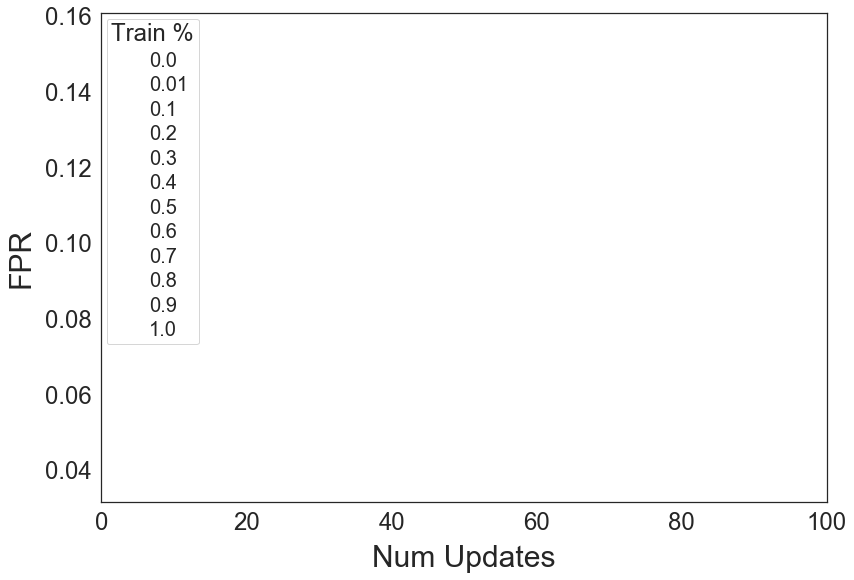

In [108]:
fig = plt.figure(figsize=(13, 9))
ax = fig.add_subplot(111)
g = sns.lineplot(x="update", y="rate", hue="train_percentage", data=data_non_cumulative.loc[data_non_cumulative["type"] == "fpr"], legend="full", ax=ax, palette=sns.cubehelix_palette(12, rot=0.5, hue=1, light=0.85, gamma=0.0))

ax.set_xlabel("Num Updates", size=30, labelpad=10.0)
ax.set_ylabel("FPR", size=30, labelpad=10.0)
ax.tick_params(axis='both', which='major', labelsize=24)
ax.tick_params(axis='both', which='minor', labelsize=24)

ax.set_xlim([0, num_updates])

legend = ax.legend(title="Train %", title_fontsize=24, labels=train_percentages, loc="upper left")
legend.texts[0].set_size(20)

fig.savefig("figures/history_effect/updated_fpr_non_cumulative_gaussian.png", dpi=300)
fig.savefig("figures/history_effect/updated_fpr_non_cumulative_gaussian.pdf")

## Cumulative Online Update with Training Data

In [83]:
n_train = 1000
n_update = 1000
n_test = 5000

seeds = 100
num_updates = 100
train_percentages = [0.0, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

### Gaussian Data

In [84]:
m0 = -1
m1 = 1

s0 = 1
s1 = 1

p0 = 0.5
p1 = 1 - p0

data_fn = gaussian_dataset_wrapper(m0, m1, s0, s1, p0, p1)

In [ ]:
results_cumulative = train_update_loop_temporal(n_train, n_update, n_test, update_model_feedback_with_training_cumulative, num_updates, train_percentages, seeds, data_fn)

0
1
2
3
4
5
6
7


In [86]:
data_cumulative = results_to_dataframe_temporal(results_cumulative, num_updates, train_percentages, seeds)

484800
484800
484800
484800


In [87]:
data_cumulative = pd.DataFrame(data_cumulative)

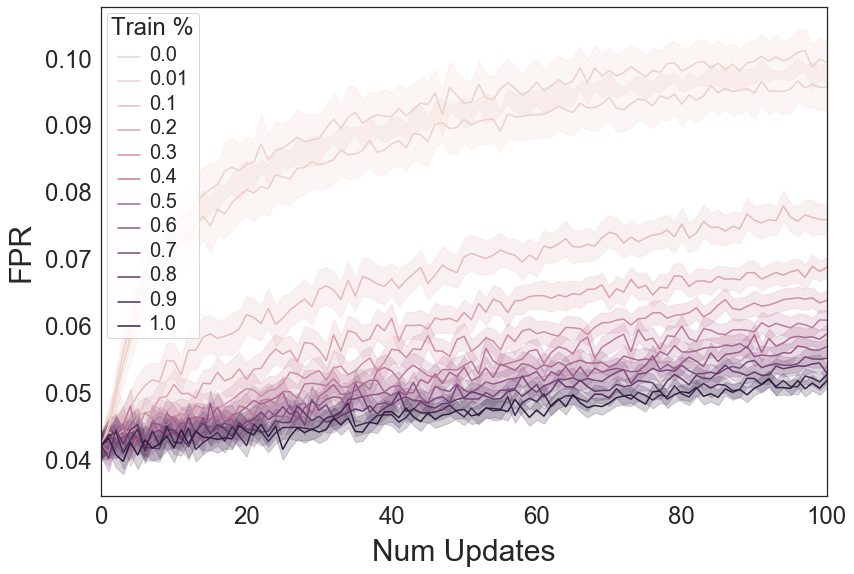

In [91]:
fig = plt.figure(figsize=(13, 9))
ax = fig.add_subplot(111)
g = sns.lineplot(x="update", y="rate", hue="train_percentage", data=data_cumulative.loc[data_cumulative["type"] == "fpr"], legend="full", ax=ax)

ax.set_xlabel("Num Updates", size=30, labelpad=10.0)
ax.set_ylabel("FPR", size=30, labelpad=10.0)
ax.tick_params(axis='both', which='major', labelsize=24)
ax.tick_params(axis='both', which='minor', labelsize=24)

ax.set_xlim([0, num_updates])

legend = ax.legend(title="Train %", title_fontsize=24, labels=train_percentages, loc="upper left")
legend.texts[0].set_size(20)

fig.savefig("figures/history_effect/updated_fpr_cumulative_gaussian.png", dpi=300)
fig.savefig("figures/history_effect/updated_fpr_cumulative_gaussian.pdf")

In [ ]:
legend.texts

In [ ]:
legend.texts

In [ ]:
g.get_legend()

In [ ]:
g.legend()

In [ ]:
legend.texts[0]

In [ ]:
legend.